In [23]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.animation as animation
import seaborn as sns
import scipy as sp
import textwrap
import workdays
%matplotlib nbagg

In [2]:
#status standing data
current_status = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/srm-datapack/standing-data/standing-data-current-status.csv')
# Which AUs belong to which ministry standing data
au_ministry_data = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/srm-datapack/standing-data/standing-data-au-ministry.csv')
# Import KRG Holidays Standing data
krg_holidays = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/srm-datapack/standing-data/standing-data-krg-holidays.csv')
#current_status.iloc[64,0]
# Analysis date
analysis_date = datetime(2023, 3, 1)
# Holding date for error handling
holding_date = pd.NaT
# Import Raw Data
df = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/raw-data/srm-raw-data/230301-srm-raw-data.csv', low_memory=False)
# Define function to remove extra characters from current state string in the raw data
def remove_extra_chars(string):
    return string.split(' $')[0]

# Apply function to 'Current State' column
df['Current State'] = df['Current State'].apply(remove_extra_chars)
# Columns to keep immediately, filtering out the many columns that are unneeded in the raw data
df_columns_to_keep = [
        'Srid','Date Submitted To Mofe','Approval Number Issued At','Ministry Input Id Issued At',
        'Ministry Id Issued At','Ministry Diwan Reviewer Action Date','Ministry Diwan Decision Maker Action Date',
        'Entity','Account Code','Exchange Rate','Total Cost Of Line','Amended Total Cost Of Line',
        'Savings Of Line','Total Sr Savings','Spending Team Action','Spending Team Action Date',
        'Price Evaluation Action','Price Evaluation Action Date','Engineering Directorate Action',
        'Engineering Directorate Action Date','Publications Directorate Action','Publications Directorate Action Date',
        'Director Of Spending Action','Director Of Spending Action Date','Dg Pa Action','Dg Pa Action Date',
        'Minister Of Finance Action','Minister Of Finance Action Date','Com Action','Com Action Date',
        'Second Round Ministry Diwan Reviewer Action Date','Second Round Ministry Diwan Decision Maker Action Date',
        'Second Round Spending Team Action Date','Second Round Director Of Spending Action Date',
        'Second Round Dg Pa Action Date','Second Round Minister Of Finance Action Date','Second Round Com Action Date',
        'Second Round Final Approval Date','Final Approval Date','Current State']
df_filtered = df.loc[:, df_columns_to_keep]
#df_filtered.head(5)

In [3]:
# Create a Most Recent Action column
#columns to include are all the columns from which the 'most recent action' could be. I.e. the most recent action
# is the date that is most recent of the actions listed below.
columns_to_include = [
        'Date Submitted To Mofe','Approval Number Issued At','Ministry Input Id Issued At',
        'Ministry Id Issued At','Ministry Diwan Reviewer Action Date','Ministry Diwan Decision Maker Action Date',
        'Spending Team Action Date',
        'Price Evaluation Action Date',
        'Engineering Directorate Action Date','Publications Directorate Action Date',
        'Director Of Spending Action Date','Dg Pa Action Date',
        'Minister Of Finance Action Date','Com Action Date',
        'Second Round Ministry Diwan Reviewer Action Date','Second Round Ministry Diwan Decision Maker Action Date',
        'Second Round Spending Team Action Date','Second Round Director Of Spending Action Date',
        'Second Round Dg Pa Action Date','Second Round Minister Of Finance Action Date',
        'Second Round Com Action Date','Second Round Final Approval Date','Final Approval Date']

df_filtered['Most Recent Action'] = df_filtered[columns_to_include].max(axis=1)

# convert date_column to datetime format
df_filtered['Most Recent Action'] = pd.to_datetime(df_filtered['Most Recent Action'], format='%Y-%m-%d %I:%M %p', errors='coerce').fillna(pd.to_datetime(df_filtered['Most Recent Action'], format='%Y-%m-%d', errors='coerce'))
# Display updated dataframe
#df['Current State'].unique()

# Merge standing data and raw data to get the status columns
current_status['Current State'] = current_status['Current State'].str.upper()
df_filtered['Current State'] = df_filtered['Current State'].str.upper()
df_filtered = pd.merge(df_filtered, current_status,how='left', on='Current State')

In [4]:
# ADD STATUS COLUMN
def final_status(row):
    if row['Current State'] == "REVOKED" and row['Date Submitted To Mofe'] == "-":
        
        return "Not Submitted"
    
    elif row['Current State'] == "REVOKED" and row['Final Approval Date'] != "-":
        if row['Minister Of Finance Action'] == "Approved By Minister Of Finance" or row['Minister Of Finance Action'] == "Amended and Approved By Minister Of Finance" or  row['Minister Of Finance Action'] == "Pending Tender":
                
            return "Revoked After Approval"
        
        elif row['Com Action'] == "Approved By Council Of Ministers" or row['Com Action'] == "Amended And Approved By Council Of Ministers" or row['Com Action'] == "Pending Tender By Council Of Ministers":
                
            return "Revoked After Approval"
        
        elif row['Minister Of Finance Action'] == "Rejected By Minister Of Finance" or row['Com Action'] == "Rejected By Council Of Ministers":
                
            return "Revoked After Rejection"
        
    elif row['Status'] == 'In process':
        return 'In Process'
    
    elif row['Status'] == 'Not submitted':
        return 'Not Submitted'
    
    elif row['Status'] == 'Revoked':
        return 'Revoked'
    
    elif row['Status'] == 'Rejected':
        return 'Rejected'
    
    elif row['Status'] == 'Approved':
        if row['Total Sr Savings'] == 0:
            return 'Approved'
        else:
            return 'Amended'
    else:
        return np.nan
    
df_filtered['Final Status'] = df_filtered.apply(final_status, axis=1)
# Replace '-' values with zeros in the 'Savings Of Line' column and blanks in the exchange rate column
# same for amended total cost of line, and total cost of line. and exchange rate remove na's

In [5]:
df_filtered['Savings Of Line'] = df_filtered['Savings Of Line'].replace('-', 0).fillna(0)
df_filtered['Amended Total Cost Of Line'] = df_filtered['Amended Total Cost Of Line'].replace('-', 0).fillna(0)
df_filtered['Total Cost Of Line'] = df_filtered['Total Cost Of Line'].replace('-', 0).fillna(0)
df_filtered['Exchange Rate'] = df_filtered['Exchange Rate'].fillna(0)

# Convert the 'Savings Of Line' column to float type
df_filtered['Savings Of Line'] = df_filtered['Savings Of Line'].astype(float)
# Convert the 'Amended Total Cost Of Line' column to float type
df_filtered['Amended Total Cost Of Line'] = df_filtered['Amended Total Cost Of Line'].astype(float)
# Convert the 'Savings Of Line' column to float type
df_filtered['Total Cost Of Line'] = df_filtered['Total Cost Of Line'].astype(float)
### ADD 'LINE ITEM SAVINGS IQD'
df_filtered['Line Item Savings IQD'] = df_filtered.apply(lambda row:
                                                         row['Exchange Rate'] * row['Savings Of Line'], axis=1)
### ADD 'Amended Line Item IQD'
df_filtered['Amended Line Item IQD'] = df_filtered.apply(lambda row:
                                                         row['Exchange Rate'] * row['Amended Total Cost Of Line'], axis=1)
### Add 'Original Line Item IQD'
df_filtered['Original Line Item IQD'] = df_filtered.apply(lambda row:
                                                         row['Exchange Rate'] * row['Total Cost Of Line'], axis=1)
### ADD 'Original Total Cost of SR'

# Group the rows of the DataFrame by the values in 'Srid',
# and calculate the sum of 'Original Line Item IQD' for each group
sum_original = df_filtered.groupby('Srid')['Original Line Item IQD'].sum()

# Create a new column 'Original Total Cost of SR' with the calculated values
df_filtered['Original Total Cost of SR'] = df_filtered['Srid'].map(sum_original)

In [6]:
# Add ministry column
df_filtered = pd.merge(df_filtered, au_ministry_data,how='left', on='Entity')
#df_filtered_ministry.head(5)

In [7]:
# Add time since last action column
def days_between_dates(row):
#    date1 = datetime.strptime(row['Most Recent Action'], '%Y-%m-%d')
#    date2 = datetime.strptime(analysis_date, '%Y-%m-%d')
    days = (analysis_date - row['Most Recent Action']).days
    return days

df_filtered['days_since_last_action'] = df_filtered.apply(days_between_dates, axis=1)


In [8]:
## Structuring and formatting the KRG holidays data XXXXX - this data will need to be continually updated.
# Convert date strings to datetime objects
krg_holidays['holiday_date'] = pd.to_datetime(krg_holidays['holiday_date'])
holiday_dates = krg_holidays['holiday_date']

In [9]:
# Holding date for error handling
holding_date = pd.NaT

# converting all the relevant times from strings to datetimes and cleaning null entries
df_filtered['Most Recent Action'] = pd.to_datetime(df_filtered['Most Recent Action'])

df_filtered['Date Submitted To Mofe'] = df_filtered['Date Submitted To Mofe'].replace('-', holding_date).fillna(holding_date)
df_filtered['Date Submitted To Mofe'] = pd.to_datetime(df_filtered['Date Submitted To Mofe'])

df_filtered['Spending Team Action Date'] = df_filtered['Spending Team Action Date'].replace('-', holding_date).fillna(holding_date)
df_filtered['Spending Team Action Date'] = pd.to_datetime(df_filtered['Spending Team Action Date'])

In [10]:
## Need to chekc weekend times and holiday times for this
# Define a function to calculate the total processing time
def tot_processing_time(row):
    if pd.isna(row['Date Submitted To Mofe']) or pd.isna(row['Most Recent Action']):
        days_processing = -1
    elif row['Final Status'] == 'In Process':
        days_processing = workdays.networkdays(row['Date Submitted To Mofe'], analysis_date, holiday_dates)
    else:
        days_processing = workdays.networkdays(row['Date Submitted To Mofe'],row['Most Recent Action'], holiday_dates)
    return days_processing
# Apply function rowswise
df_filtered['tot_days_processing'] = df_filtered.apply(tot_processing_time, axis=1)

In [11]:
# Define a function to calculate the analyst processing time
def analyst_processing_time(row):
    if pd.isna(row['Date Submitted To Mofe']) or pd.isna(row['Spending Team Action Date']):
        days_processing = 0
    elif row['Final Status'] == 'In Process':
        days_processing = workdays.networkdays(row['Date Submitted To Mofe'], analysis_date, holiday_dates)
    else:
        days_processing = workdays.networkdays(row['Date Submitted To Mofe'],row['Spending Team Action Date'], holiday_dates)
    return days_processing
# Apply function rowswise
df_filtered['analyst_days_processing'] = df_filtered.apply(analyst_processing_time, axis=1)

In [12]:
## Create list of weeks from 2021-03-01 until now
start_date = datetime(2021, 3, 1)
current_date = datetime.now()
date_lista = [start_date]

while date_lista[-1] < current_date:
    date_lista.append(date_lista[-1] + timedelta(weeks=1))

date_list = date_lista[0:-1]

In [13]:
## Initialise the dataframe that we are going to populate with our data
columns = ['Average Total Days Processing', 'Average Analyst Days Processing']
zero_data = np.zeros(shape=(len(date_list),len(columns)))
process_times_df = pd.DataFrame(data=zero_data,index=date_list, columns=columns)

In [14]:
# We ignore in process requests for the time being
status_to_ignore = ['In Process', 'Not Submitted']
df_filtered_pt = df_filtered[~df_filtered['Final Status'].isin(status_to_ignore)]

In [15]:
df_filtered['Final Status'].unique()

array(['Rejected', 'In Process', 'Amended', 'Approved',
       'Revoked After Rejection', 'Revoked', 'Revoked After Approval',
       'Not Submitted'], dtype=object)

In [16]:
def compute_averages(row):
    start_date = row.name
    end_date = row.name - pd.DateOffset(weeks=1)
    mask = (df_filtered_pt['Most Recent Action'] >= end_date) & (df_filtered_pt['Most Recent Action'] < start_date)
    int_df = df_filtered_pt.loc[mask]
    unique_srids = int_df['Srid'].unique()
    filtered_int_df = int_df[int_df['Srid'].isin(unique_srids)]
    total_days_avg = filtered_int_df['tot_days_processing'].mean()
    analyst_days_avg = filtered_int_df['analyst_days_processing'].mean()
    return pd.Series({'Average Total Days Processing': total_days_avg, 'Average Analyst Days Processing': analyst_days_avg})

process_times_df = process_times_df.apply(compute_averages, axis=1)


In [17]:
df_filtered.columns

Index(['Srid', 'Date Submitted To Mofe', 'Approval Number Issued At',
       'Ministry Input Id Issued At', 'Ministry Id Issued At',
       'Ministry Diwan Reviewer Action Date',
       'Ministry Diwan Decision Maker Action Date', 'Entity', 'Account Code',
       'Exchange Rate', 'Total Cost Of Line', 'Amended Total Cost Of Line',
       'Savings Of Line', 'Total Sr Savings', 'Spending Team Action',
       'Spending Team Action Date', 'Price Evaluation Action',
       'Price Evaluation Action Date', 'Engineering Directorate Action',
       'Engineering Directorate Action Date',
       'Publications Directorate Action',
       'Publications Directorate Action Date', 'Director Of Spending Action',
       'Director Of Spending Action Date', 'Dg Pa Action', 'Dg Pa Action Date',
       'Minister Of Finance Action', 'Minister Of Finance Action Date',
       'Com Action', 'Com Action Date',
       'Second Round Ministry Diwan Reviewer Action Date',
       'Second Round Ministry Diwan Decision

In [18]:
start_datea =  datetime(2023, 1, 13)
end_dateb = datetime(2023,1,7)
cols_to_inc = ['Srid', 'Date Submitted To Mofe','Spending Team Action Date',
               'Current State', 'Most Recent Action','Final Status',
              'tot_days_processing','analyst_days_processing']
df_filtered_pt.loc[(df_filtered_pt['Most Recent Action'] >= end_dateb) & (df_filtered_pt['Most Recent Action'] < start_datea),cols_to_inc]



,Srid,Date Submitted To Mofe,Spending Team Action Date,Current State,Most Recent Action,Final Status,tot_days_processing,analyst_days_processing
64185,SRID-11460,2022-03-30 14:01:00,2022-04-24 12:34:00,COMPLETE AND SENT BACK TO REQUESTER FOR PR SUB...,2023-01-08 11:53:00,Approved,190,15
64186,SRID-11460,2022-03-30 14:01:00,2022-04-24 12:34:00,COMPLETE AND SENT BACK TO REQUESTER FOR PR SUB...,2023-01-08 11:53:00,Approved,190,15
64187,SRID-11460,2022-03-30 14:01:00,2022-04-24 12:34:00,COMPLETE AND SENT BACK TO REQUESTER FOR PR SUB...,2023-01-08 11:53:00,Approved,190,15
64188,SRID-11460,2022-03-30 14:01:00,2022-04-24 12:34:00,COMPLETE AND SENT BACK TO REQUESTER FOR PR SUB...,2023-01-08 11:53:00,Approved,190,15
64189,SRID-11460,2022-03-30 14:01:00,2022-04-24 12:34:00,COMPLETE AND SENT BACK TO REQUESTER FOR PR SUB...,2023-01-08 11:53:00,Approved,190,15
...,...,...,...,...,...,...,...,...
120301,SRID-20821,2022-11-20 14:21:00,2023-01-08 11:36:00,COMPLETE AND SENT BACK TO REQUESTER FOR PR SUB...,2023-01-08 12:22:00,Approved,34,34
126608,SRID-21923,2022-12-04 09:08:00,2022-12-12 09:05:00,SENT BACK TO REQUESTING ENTITY FOR SECOND ROUND,2023-01-09 00:00:00,Approved,25,5
126609,SRID-21923,2022-12-04 09:08:00,2022-12-12 09:05:00,SENT BACK TO REQUESTING ENTITY FOR SECOND ROUND,2023-01-09 00:00:00,Approved,25,5
126610,SRID-21923,2022-12-04 09:08:00,2022-12-12 09:05:00,SENT BACK TO REQUESTING ENTITY FOR SECOND ROUND,2023-01-09 00:00:00,Approved,25,5


<IPython.core.display.Javascript object>


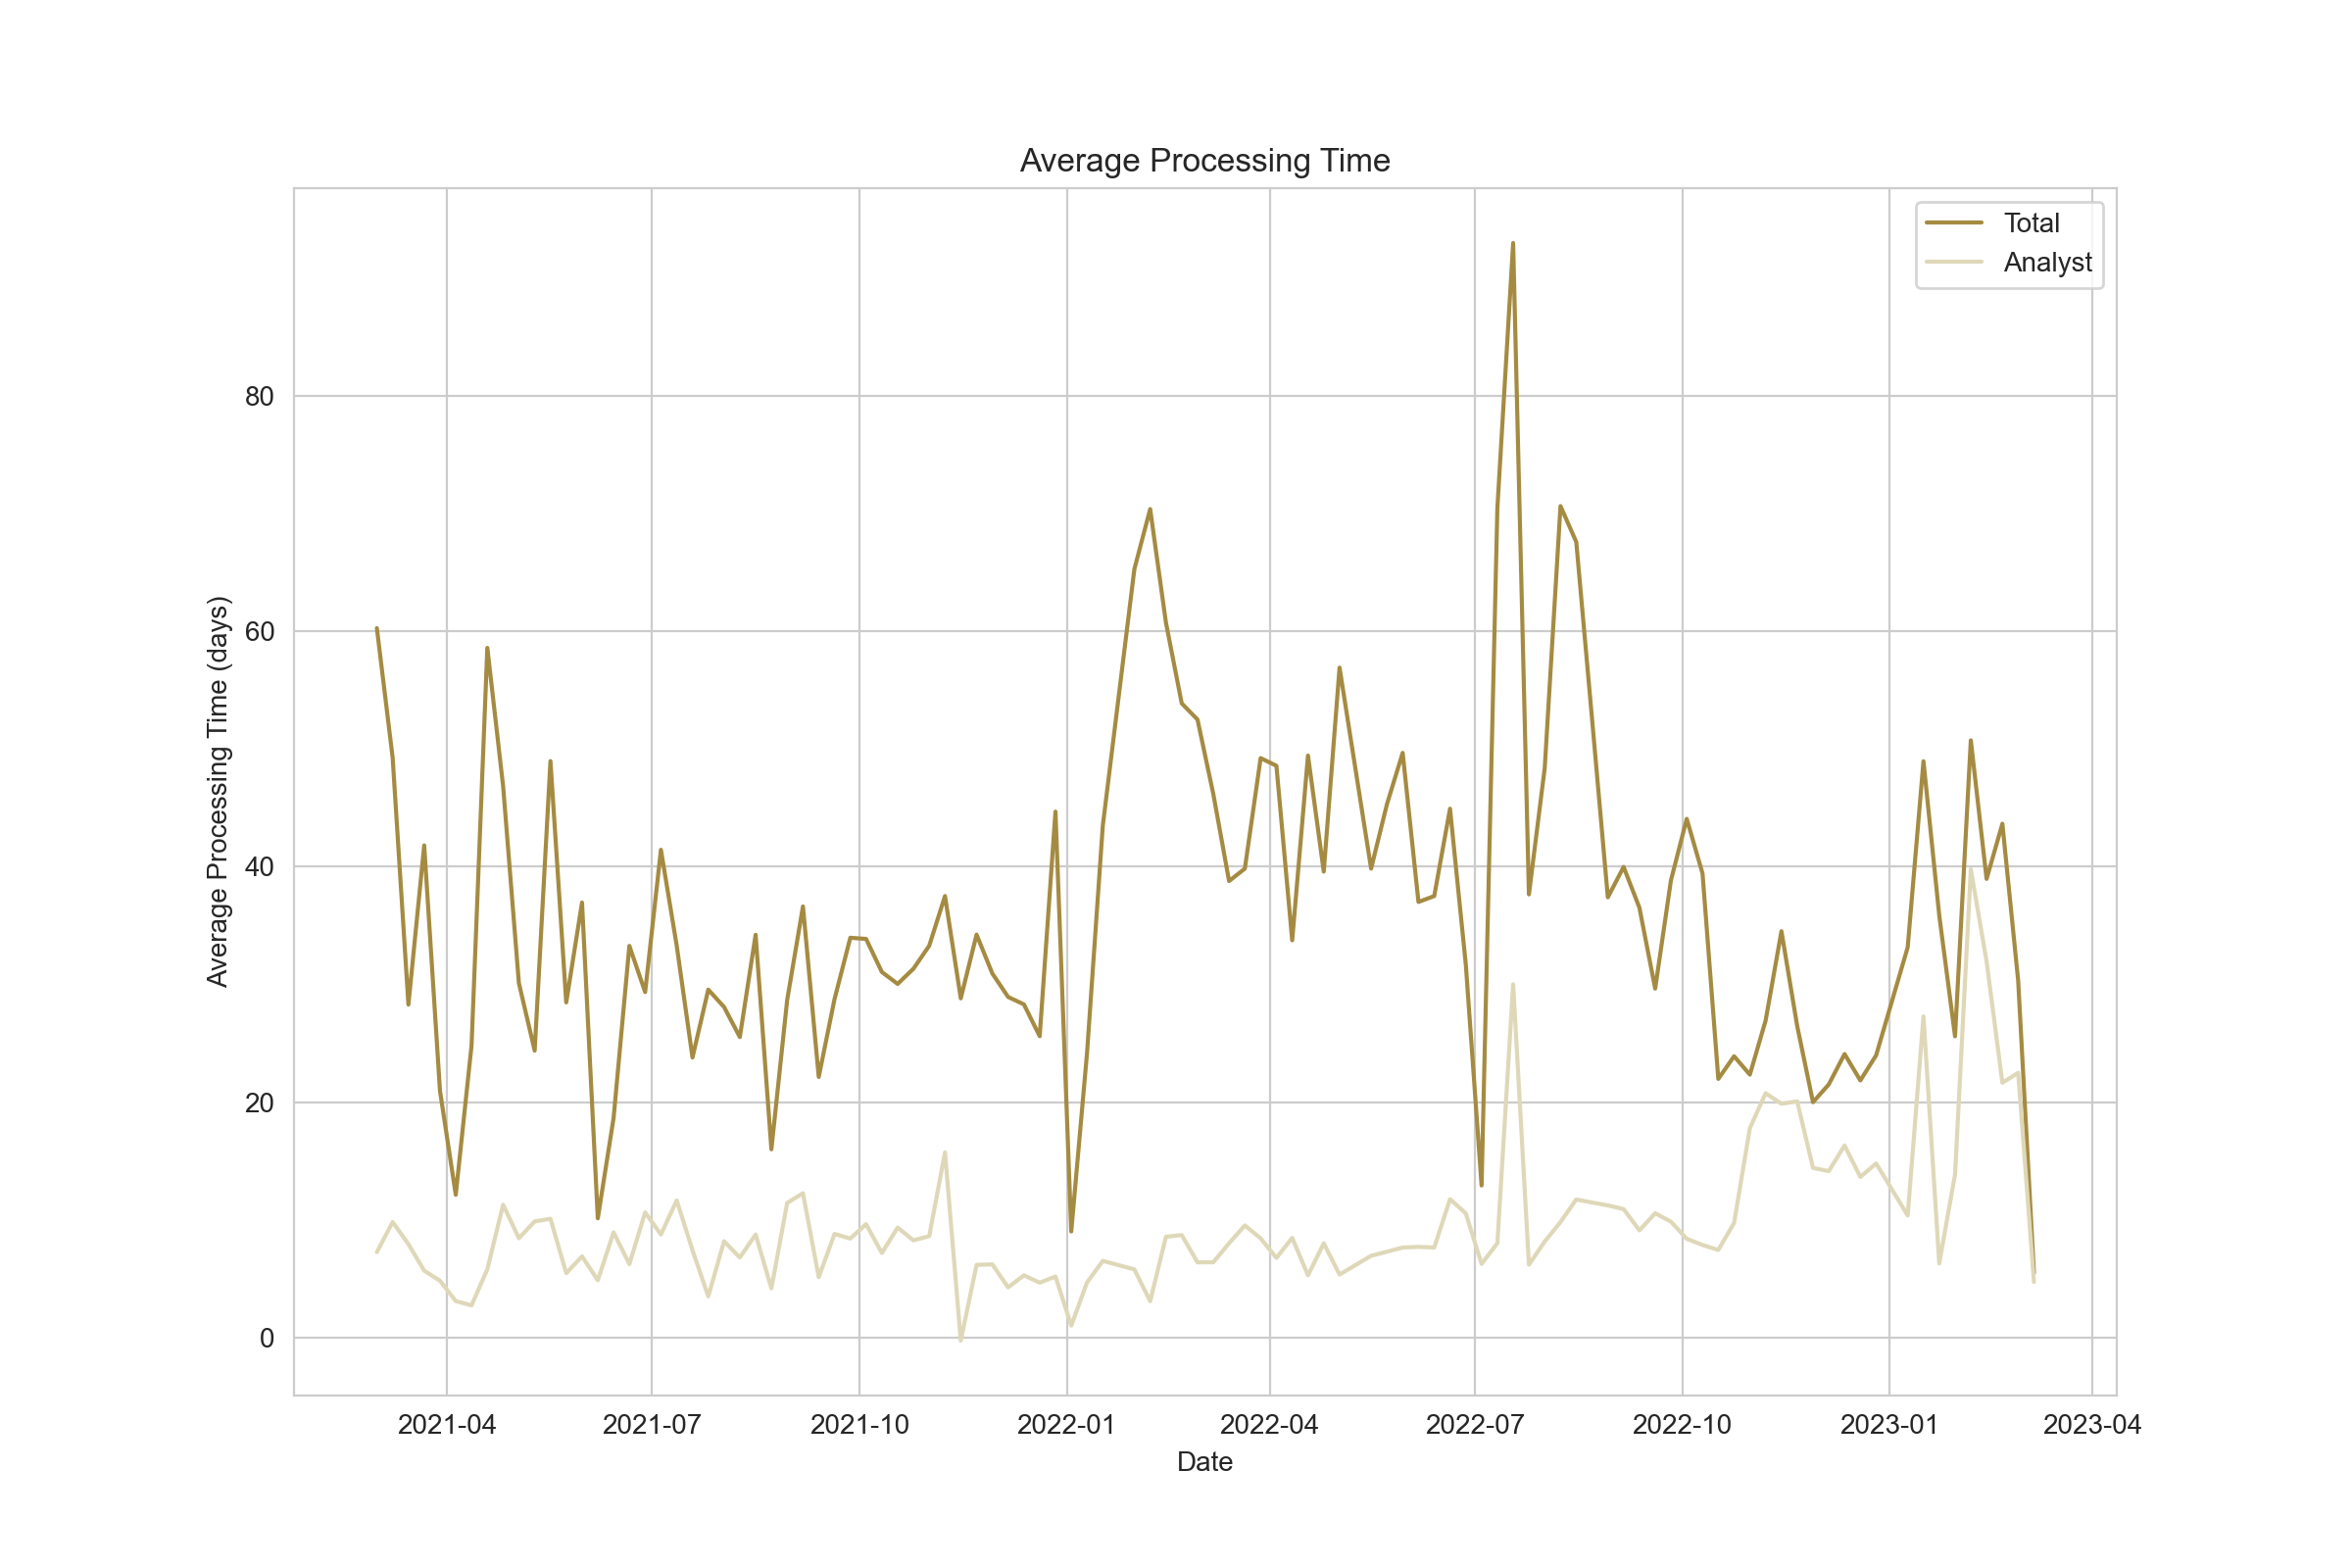

In [19]:
# Plotting the data
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
plt.title("Average Processing Time")
sns.lineplot(data=process_times_df, x=process_times_df.index, y="Average Total Days Processing", label="Total", color='#a58b42')
sns.lineplot(data=process_times_df, x=process_times_df.index, y="Average Analyst Days Processing", label="Analyst", color='#dfd8b8')
plt.xlabel("Date")
plt.ylabel("Average Processing Time (days)")
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


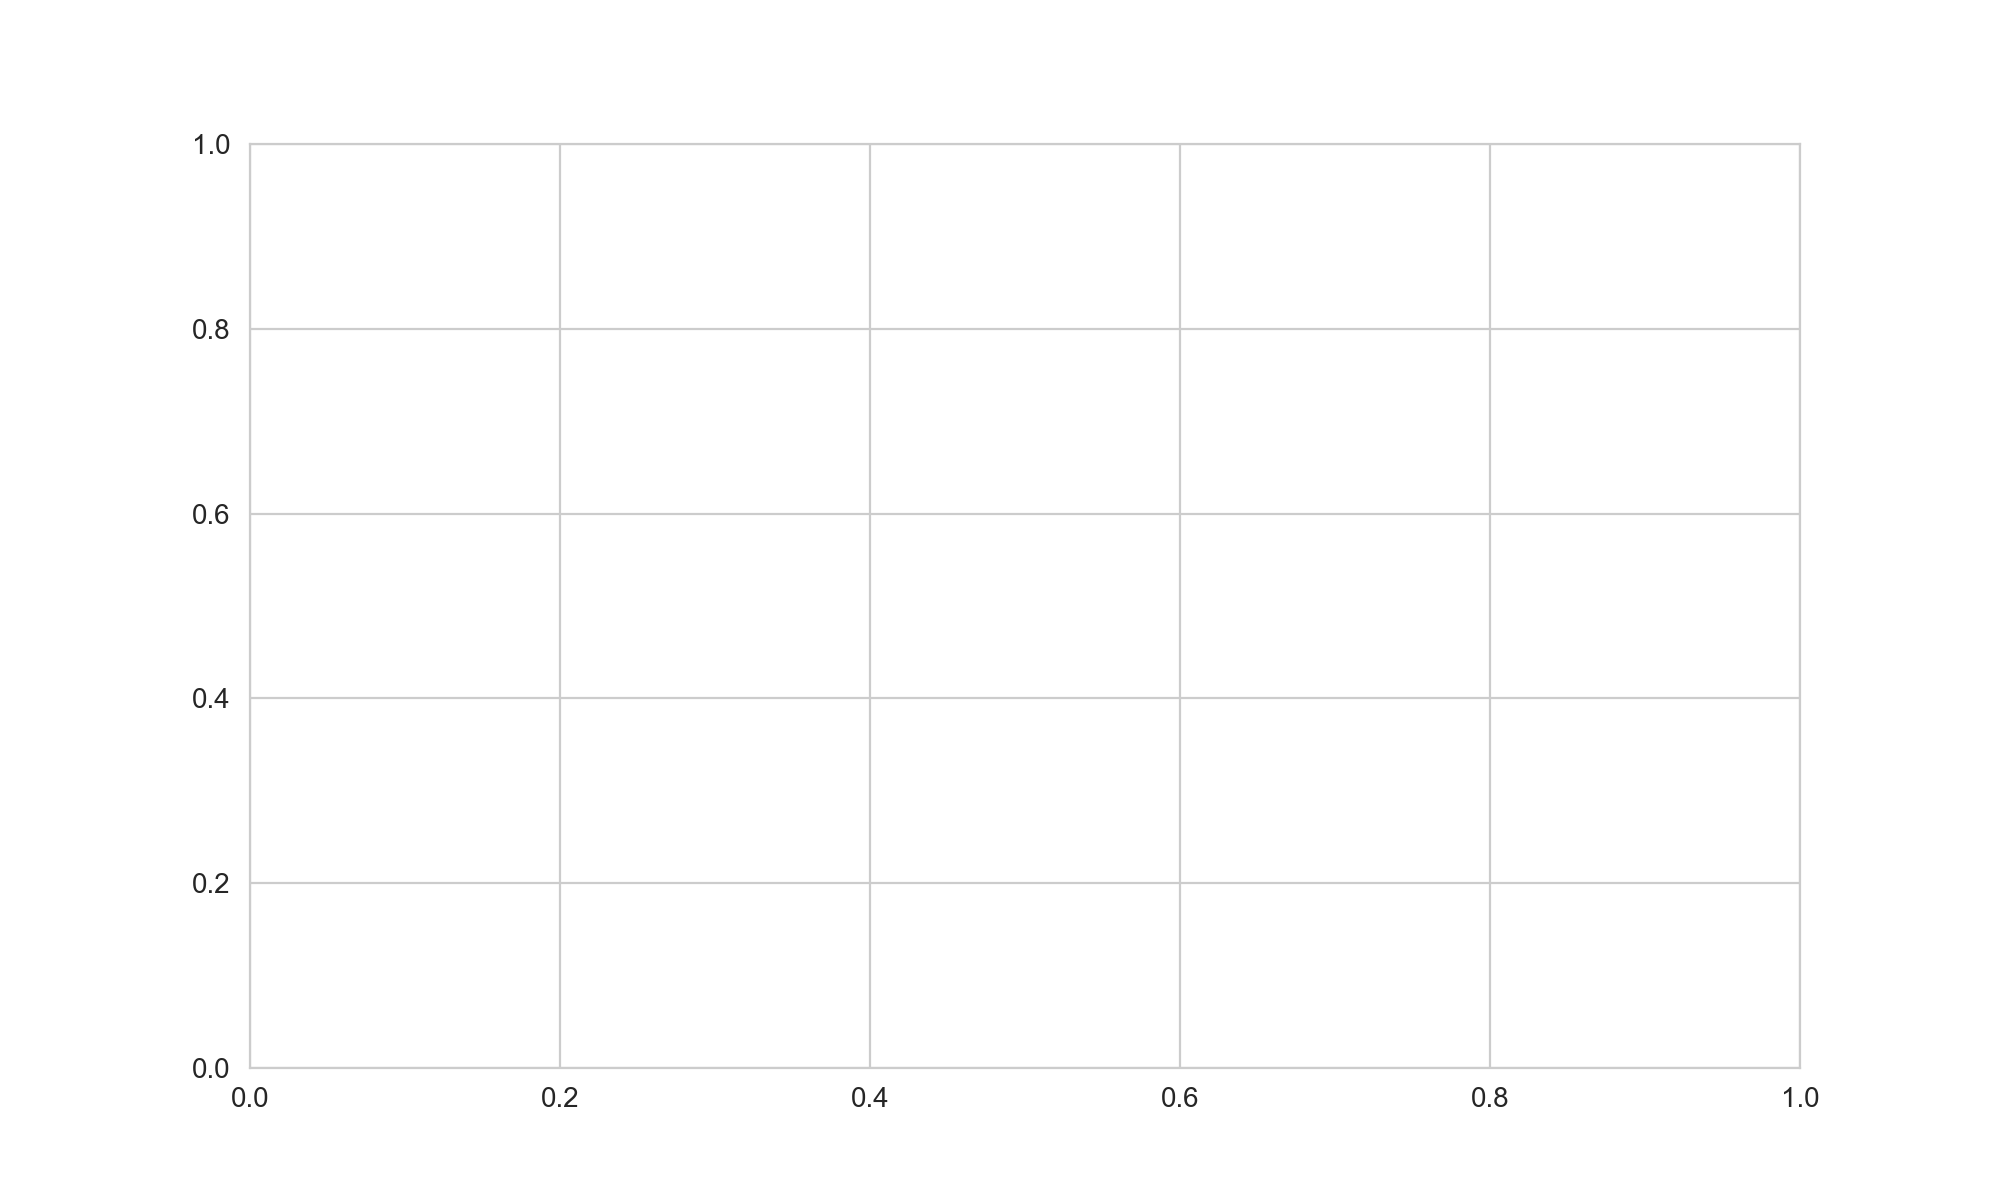

In [20]:
# set up the figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# define the animation function
def animate(i):
    # get the data up to the current index i
    data = process_times_df.iloc[:i+1]
    # clear the current axis
    ax.clear()
    # plot the total line
    sns.lineplot(x=data.index, y=data['Average Total Days Processing'], ax=ax, label='Total')
    # plot the analyst line
    sns.lineplot(x=data.index, y=data['Average Analyst Days Processing'], ax=ax, label='Analyst')
    # set the title and axis labels
    ax.set_title('Average Processing Times Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Days')
    # set the x-tick labels to display only the month and day
    ax.set_xticklabels(data.index.strftime('%m-%d'), rotation=45, ha='right')
    # add a legend
    ax.legend()

# create the animation object
ani = animation.FuncAnimation(fig, animate, frames=len(process_times_df))

# display the animation
plt.show()
